# Binary Classification with PyTorch

- In [models](MODELS.md) section for demonstration purposes a regression model was created an trained.
- Regression models predict a continuous value.
- But a classification model outputs a discrete value (ex. dog, cat, alligator).
- Here, a binary classification will be conducted using Scikit Learn circles dataset.
- It is called binary because only one or another class label is predicted. (0 or 1)

## Imports

In [1]:
import torch
import torch.nn as nn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

## Device Agnostic Code

Utilizing a GPU if available. Else, fall back to CPU.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## Getting Data

- Sklearn's `make_circles` method, generates points in x,y coordinates marked in a cartesian coordinate system. Every point in space also has a label indicating it's class label namely 0 or 1.
- For more info, refer to https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html

In [3]:
X, y = make_circles(n_samples=1000, noise=0.04, random_state=7)

X.shape, y.shape

((1000, 2), (1000,))

In [4]:
X[:5], y[:5]

(array([[-0.75876333, -0.27344342],
        [-0.47799317, -0.8753975 ],
        [-0.97185957, -0.24912226],
        [-0.66952837, -0.50331704],
        [-0.90720545,  0.40643155]]),
 array([1, 0, 0, 1, 0], dtype=int64))

### Splitting Data For Train and Test

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

### Visualizing Data

In [6]:
import pandas as pd
df_circles = pd.DataFrame({"X1": X[:, 0],
                           "X2": X[:, 1],
                           "label": y})

df_circles.head()

,X1,X2,label
0,-0.758763,-0.273443,1
1,-0.477993,-0.875398,0
2,-0.971860,-0.249122,0
3,-0.669528,-0.503317,1
4,-0.907205,0.406432,0


In [7]:
df_circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

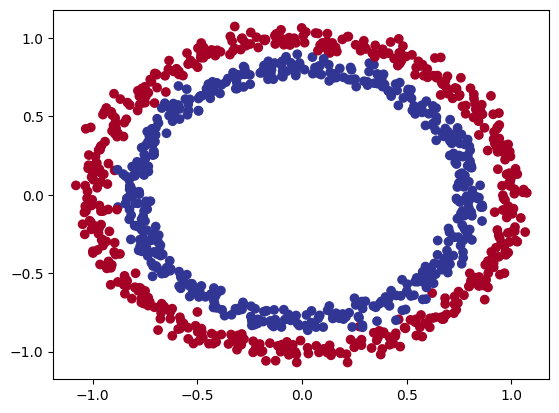

In [8]:
plt.plot()
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

###  Create Tensors from Numpy Arrays

In [9]:
X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)

## Creating a Model 

- The model has one input with 2 units. One for coordinate in x-axis, one for coordinate in y-axis. Aligning the shape of dataset used -> (n_samples, 2).
- Followed by one hidden layer with 8 units. Can have more or less neurons. Play around with it as you wish.
- Lastly one unit for output.

In [10]:
# Create model class
class BinaryClassificationModelv1(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_1 = nn.Linear(in_features=2, out_features=8)
        self.linear_2 = nn.Linear(in_features=8, out_features=1)
    
    def forward(self, x):
        # input -> linear_1 -> linear_2 -> output
        return self.linear_2(self.linear_1(x))
    
torch.manual_seed(7)
model0 = BinaryClassificationModelv1()

model0.state_dict()

OrderedDict([('linear_1.weight',
              tensor([[ 0.0494, -0.4260],
                      [ 0.2252,  0.2219],
                      [-0.3779, -0.1060],
                      [-0.4142,  0.1835],
                      [-0.1905,  0.4968],
                      [ 0.5020,  0.0720],
                      [-0.3015, -0.4153],
                      [-0.0777, -0.1990]])),
             ('linear_1.bias',
              tensor([ 0.3117, -0.6038,  0.6646, -0.5547,  0.5415, -0.1228,  0.3637,  0.2756])),
             ('linear_2.weight',
              tensor([[ 0.0148,  0.0659,  0.2685,  0.0909,  0.1876, -0.2735,  0.2517,  0.1217]])),
             ('linear_2.bias', tensor([0.0896]))])

### Alternative Model Creation Syntax

In [11]:
# Alternative model creation syntax - useful for simple models

torch.manual_seed(7)
model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
)

# As you can see generated model is the same.
print(model0.state_dict())

# Take model to specified device
model0.to(device)

print("The model is in device:", next(model0.parameters()).device)

OrderedDict([('0.weight', tensor([[ 0.0494, -0.4260],
        [ 0.2252,  0.2219],
        [-0.3779, -0.1060],
        [-0.4142,  0.1835],
        [-0.1905,  0.4968],
        [ 0.5020,  0.0720],
        [-0.3015, -0.4153],
        [-0.0777, -0.1990]])), ('0.bias', tensor([ 0.3117, -0.6038,  0.6646, -0.5547,  0.5415, -0.1228,  0.3637,  0.2756])), ('1.weight', tensor([[ 0.0148,  0.0659,  0.2685,  0.0909,  0.1876, -0.2735,  0.2517,  0.1217]])), ('1.bias', tensor([0.0896]))])
The model is in device: cuda:0


## Loss and Optimizer for Binary Classification

### Choosing Loss Function

- A loss function is required for measuring the distance/disturbance between true and predicted labels.
- For binary classification, Binary Cross Entropy Loss is used.

BCE -> Binary Cross Entropy

**Use BCELoss() when sigmoid applied to model output.** 
  - Requires inputs went through sigmoid activation function.
  - If you want to utilize this loss function be sure that your model output has gone through sigmoid activation.

**Use BCEWithLogitsLoss() if sigmoid not applied to model output.** 
  - Sigmoid activation is built-in with this loss.

https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss

### Choosing Optimizer

- For now, SGD is good for learning purposes. 
- If you want to try other options refer to [docs](https://pytorch.org/docs/stable/optim.html#algorithms).

In [12]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss()


# Optimizer
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

## Model Metric: Accuracy

Accuracy is the metric of a model's correct prediction power. True predicted labels are divided by total number of labels.

In [13]:
# Calculating accuracy
# Formula: (True Positives + True Negatives) / (All Predictions) * 100

def calc_accuracy(y_true, y_pred):
    tp_tn = torch.eq(y_true, y_pred).sum().item() # .sum() returns a tensor. Get the value with .item()
    acc = (tp_tn / len(y_true)) * 100

    return acc

## Working with Logits

**Logit is the raw output of a layer.** If a meaningful data is needed, logit should be sent to an activation function.

```
Raw logits -> Prediction probabilities -> Prediction label
Raw logits -> apply softmax for binary classification -> round(pred) [0-1]
Raw logits -> apply sigmoid for multiclass classification -> argmax() = index of max probability is the prediction label 
```

- Model outputs float logits but data has labelled as 0 or 1.
- For binary classification we should apply activation function to these predictions in order to compare directly with true labels.

### Observing Model Behavior

As can be seen model outputs some numbers according to the last linear layer.
- These numbers are called `logits`.
- Logits are, in deep learning, represents the data outputted from a layer.

Remembering model's forward pass:

```python
def forward(self, x):
    # input -> linear_1 -> linear_2 -> output
    return self.linear_2(self.linear_1(x))
```

In [14]:
# Let's see what our model outputs when a prediction made
model0.eval()

with torch.inference_mode():
    y_logits = model0(X_test.to(device))

y_logits[:5]

tensor([[0.7085],
        [0.8423],
        [0.2012],
        [0.2635],
        [0.6067]], device='cuda:0')

Model should output a prediction as probability. For binary classification in order to calculate this probability logits should be fed into sigmoid function. Sigmoid function generate a value between 0 and 1 and represent a probability.

- Closer to 0 means prediction label is 0.
- Similarly closer to 1 means predicted label is 1.

In [15]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.6701],
        [0.6990],
        [0.5501],
        [0.5655],
        [0.6472]], device='cuda:0')

As can be seen, data labels are not continuous float numbers, discrete like either 0 or 1.

In [16]:
# Visualize the samples from test labels.
y_test[:5]

tensor([1., 0., 0., 1., 1.])

To convert our prediction probabilities to labels we can apply a threshold. Generally 0.5 is used for binary classification but you are free to decide this value.

Since we chosen threshold as 0.5, we can simply round the number using `torch.round()`. Any value will be lower than 0.5 will be counted as 0. Meanwhile all values equal or greater than 0.5 will be counted as label 1.

In [17]:
torch.round(y_pred_probs)[:5]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

## Train Loop

**For fundamentals of models and training check out previous chapter: [Models](MODELS.md)**

Only one thing is added to train loop different from previous regression model and it is the calculation of accuracy. Model output is still sent to loss function to calculate the loss but renamed as logits. To calculate the accuracy we need to provide the predicted labels to function. So sigmoid and round is applied. 

In [18]:
# Set global seed for reproducible results. 
torch.manual_seed(7)
torch.cuda.manual_seed(7)

EPOCHS = 100
PAD = len(str(EPOCHS))

# Move data to corresponding device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# For collecting data about training
history_epochs = []
history_loss = []
history_acc = []
history_test_loss = []
history_test_acc = []

for epoch in range(1, EPOCHS+1):
    # set model to train mode
    model0.train()

    # Clean gradients from accumulation
    optimizer.zero_grad()

    # Forward pass
    y_logits = model0(X_train).squeeze() # [800, 1] -> [800]
    y_preds = torch.round(torch.sigmoid(y_logits))

    # Calculate loss and accuracy
    # Loss function BCEWithLogitsLoss() expects logits as input.
    loss = loss_fn(y_logits, y_train)
    acc = calc_accuracy(y_true=y_train, y_pred=y_preds)

    # Backpropagation
    loss.backward()

    # Adjust parameters
    optimizer.step()

    # Testing
    model0.eval()

    with torch.inference_mode():
        # Forward pass
        test_logits = model0(X_test).squeeze() # [200, 1] -> [200]
        test_preds = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = calc_accuracy(y_true=y_test, y_pred=test_preds)

        # Collect data
        history_epochs.append(epoch)
        history_loss.append(loss)
        history_acc.append(acc)
        history_test_loss.append(test_loss)
        history_test_acc.append(test_acc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:>{PAD}} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch  10 | Train Loss: 0.70567 | Train Acc: 53.25 | Test Loss: 0.69068 | Test Acc: 52.50
Epoch  20 | Train Loss: 0.69818 | Train Acc: 50.00 | Test Loss: 0.69410 | Test Acc: 52.00
Epoch  30 | Train Loss: 0.69610 | Train Acc: 49.75 | Test Loss: 0.69696 | Test Acc: 52.00
Epoch  40 | Train Loss: 0.69529 | Train Acc: 48.75 | Test Loss: 0.69847 | Test Acc: 49.50
Epoch  50 | Train Loss: 0.69483 | Train Acc: 48.38 | Test Loss: 0.69912 | Test Acc: 48.00
Epoch  60 | Train Loss: 0.69449 | Train Acc: 48.88 | Test Loss: 0.69932 | Test Acc: 47.00
Epoch  70 | Train Loss: 0.69421 | Train Acc: 48.62 | Test Loss: 0.69932 | Test Acc: 44.00
Epoch  80 | Train Loss: 0.69399 | Train Acc: 48.12 | Test Loss: 0.69923 | Test Acc: 44.00
Epoch  90 | Train Loss: 0.69379 | Train Acc: 48.12 | Test Loss: 0.69911 | Test Acc: 45.00
Epoch 100 | Train Loss: 0.69363 | Train Acc: 47.75 | Test Loss: 0.69898 | Test Acc: 45.00


In [19]:
X_test[:5]

tensor([[-0.6317, -0.4210],
        [-1.0353, -0.0738],
        [ 0.4968,  0.8805],
        [ 0.3600,  0.7080],
        [-0.3180, -0.7270]], device='cuda:0')

## Problem: Model is not Learning

There can be couple of reasons for this problem.
1. Data is not enough.
2. Model is not big enough to represent the data.
3. Model is too big for the data in hand.
4. Loss function is wrong
5. Optimizer is wrong.
6. Not enough training.

*You can change the data size, model size, loss function and the optimizer to understand.*

But let's diagnose the problem by visualizing.

Below plot is showing true labels and predicted labels colored according to it.

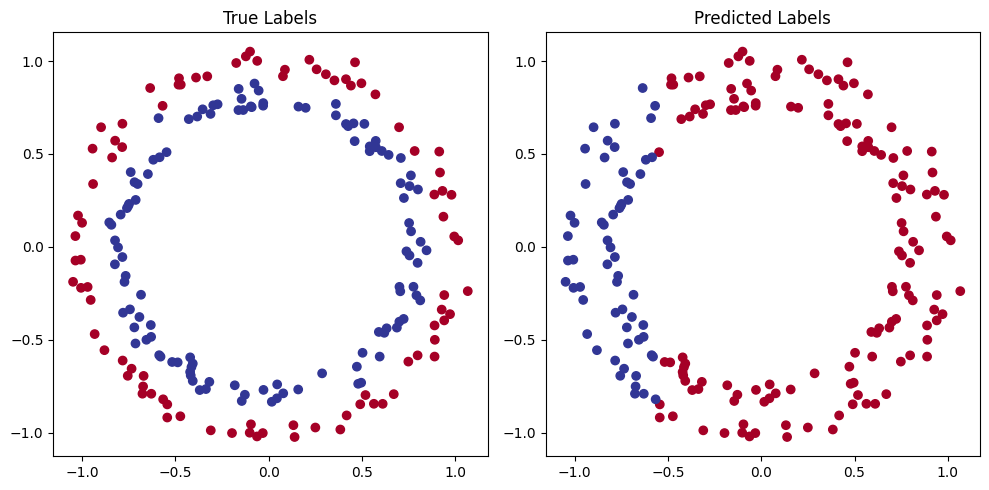

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("True Labels")
plt.scatter(x=X_test[:, 0].cpu(), y=X_test[:, 1].cpu(), c=y_test.cpu(), cmap=plt.cm.RdYlBu)

plt.subplot(1,2,2)
plt.title("Predicted Labels")
plt.scatter(x=X_test[:, 0].cpu(), y=X_test[:, 1].cpu(), c=test_preds.cpu(), cmap=plt.cm.RdYlBu)

plt.tight_layout()
plt.show()

You might have guessed what is happening by looking at plots above but for visualizing decision boundaries better we can get the help of Daniel Bourke.

In [21]:
import requests
from pathlib import Path

FILE_NAME = "helper_functions.py"

if Path(FILE_NAME).is_file():
    print(f"{FILE_NAME} already exists. Skipping downloading.")
else:
    print(f"Started downloading {FILE_NAME}.")
    try:
        request = requests.get(
            "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
        
        with open(FILE_NAME, "wb") as f:
            f.write(request.content)
            print("Download complete.")

    except Exception as e:
        print("An error occurred:", e)

helper_functions.py already exists. Skipping downloading.


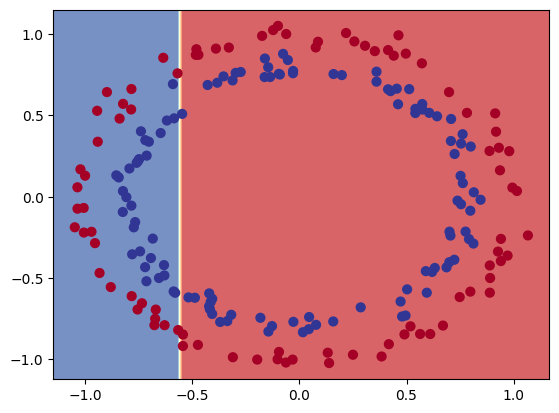

In [22]:
from helper_functions import plot_decision_boundary

plt.figure()
plot_decision_boundary(model=model0, X=X_test, y=y_test)
plt.show()

## Improving Model

- Adding more units
- Adding more layers
- Trying different activation functions
- Trying different optimizers
- Change learning rate
- Choose correct loss function for the problem
- Train for more epochs


You can try all of the above. Buf problem is really clear if you visualize the test results.

**Our model has only linear layers. Linear layers can only represent linear data. But our data is spread circular.**

**Solution:** We need to implement non-linearity in order to be able to fit non-linear data.

https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

Let's alter the model with adding some non-linearity. This way, when our model making a decision does not have to go only the same direction. Curves can be made when splitting classes from each other. Also make it a little bit bigger. With the added capacity model can learn better.

In [26]:
class CircularModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_1 = nn.Linear(in_features=2, out_features=16)
        self.linear_2 = nn.Linear(in_features=16, out_features=16)
        self.linear_3 = nn.Linear(in_features=16, out_features=1)

        # self.linear_1 = nn.Linear(in_features=2, out_features=8)
        # self.linear_2 = nn.Linear(in_features=8, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # return self.linear_2(self.relu(self.linear_1(x)))
        # !!! Do not activate last layer with relu. !!!
        return self.linear_3(self.relu(self.linear_2(self.relu(self.linear_1(x)))))
    
torch.manual_seed(7)
model1 = CircularModel()
model1.to(device)

model1

CircularModel(
  (linear_1): Linear(in_features=2, out_features=16, bias=True)
  (linear_2): Linear(in_features=16, out_features=16, bias=True)
  (linear_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

### Everything, Same Place, at Once...

Epoch  300 | Train Loss: 0.68368 | Train Acc: 54.87 | Test Loss: 0.68906 | Test Acc: 49.50
Epoch  600 | Train Loss: 0.66073 | Train Acc: 62.12 | Test Loss: 0.66628 | Test Acc: 61.50
Epoch  900 | Train Loss: 0.55034 | Train Acc: 94.88 | Test Loss: 0.55596 | Test Acc: 95.00
Epoch 1200 | Train Loss: 0.22765 | Train Acc: 98.88 | Test Loss: 0.21851 | Test Acc: 98.50
Epoch 1500 | Train Loss: 0.08333 | Train Acc: 98.88 | Test Loss: 0.07696 | Test Acc: 99.50
Epoch 1800 | Train Loss: 0.04943 | Train Acc: 99.38 | Test Loss: 0.04462 | Test Acc: 99.50
Epoch 2100 | Train Loss: 0.03649 | Train Acc: 99.50 | Test Loss: 0.03185 | Test Acc: 99.50
Epoch 2400 | Train Loss: 0.02981 | Train Acc: 99.50 | Test Loss: 0.02554 | Test Acc: 99.50
Epoch 2700 | Train Loss: 0.02566 | Train Acc: 99.50 | Test Loss: 0.02174 | Test Acc: 99.50
Epoch 3000 | Train Loss: 0.02287 | Train Acc: 99.50 | Test Loss: 0.01928 | Test Acc: 99.50


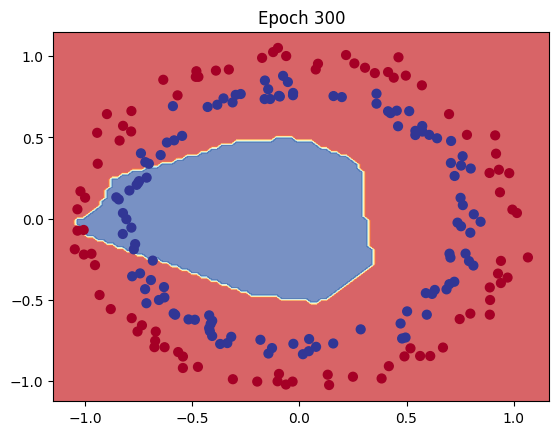

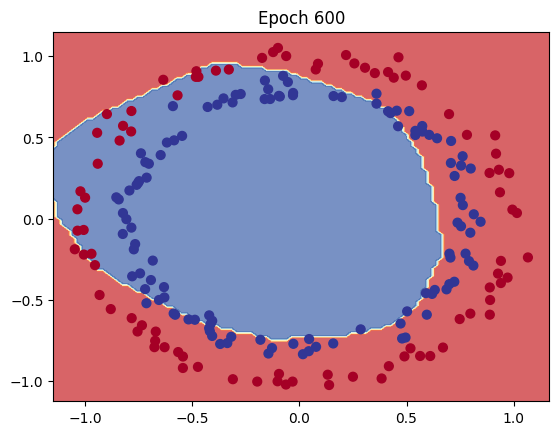

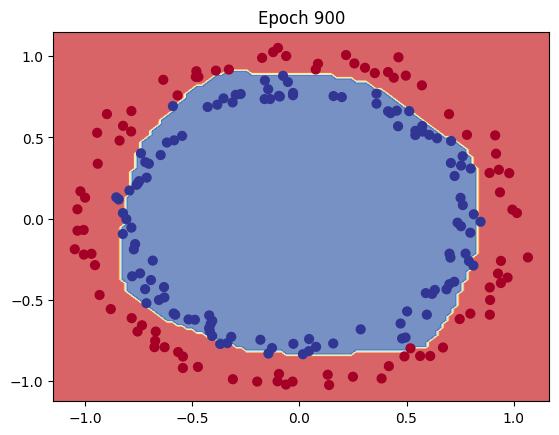

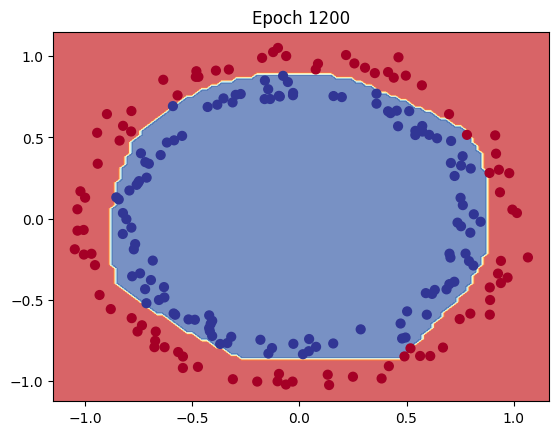

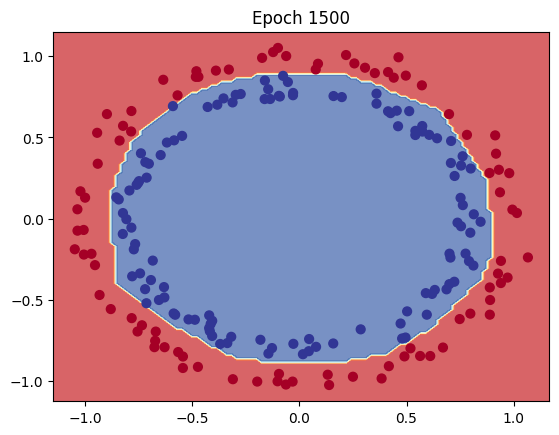

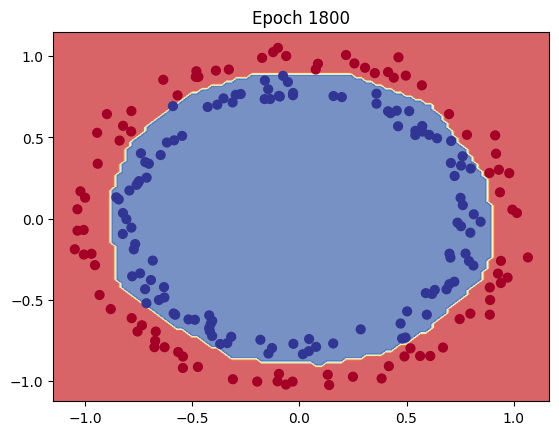

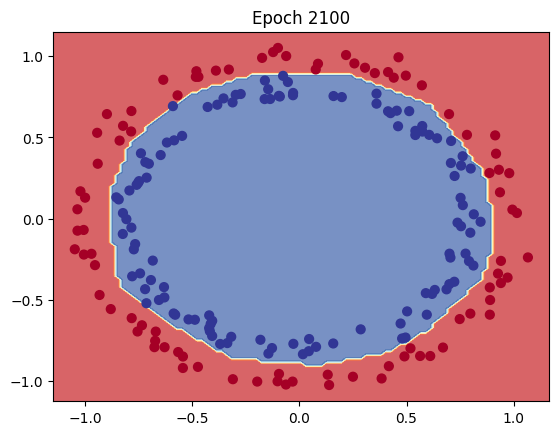

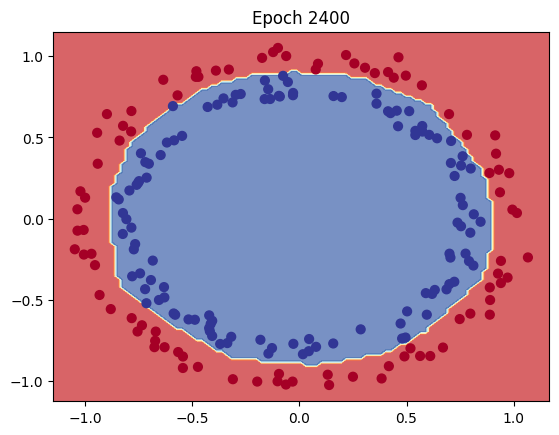

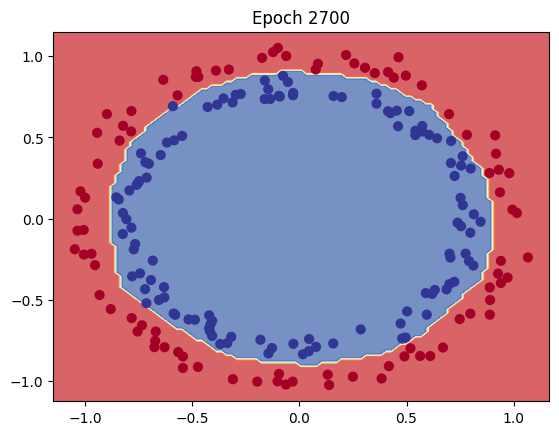

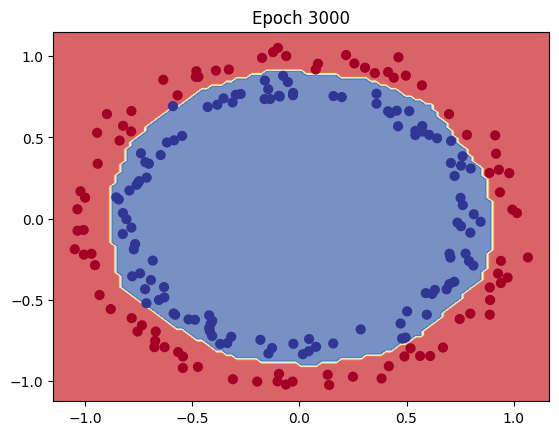

In [27]:
from sklearn.model_selection import train_test_split

# Dataset
X, y = make_circles(n_samples=1000, noise=0.04, random_state=7)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

# Loss
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

# Reproducibility
torch.manual_seed(7)
torch.cuda.manual_seed(7)

EPOCHS = 3000
PAD = len(str(EPOCHS))

# For collecting data about training
history_epochs = []
history_loss = []
history_acc = []
history_test_loss = []
history_test_acc = []

# Train loop
for epoch in range(1, EPOCHS+1):
    model1.to(device)
    # set model to train mode
    model1.train()

    # Clean gradients from accumulation
    optimizer.zero_grad()

    # Forward pass
    y_logits = model1(X_train).squeeze()  # [800, 1] -> [800]
    y_preds = torch.round(torch.sigmoid(y_logits))

    # Calculate loss and accuracy
    # Loss function BCEWithLogitsLoss() expects logits as input.
    loss = loss_fn(y_logits, y_train)
    acc = calc_accuracy(y_true=y_train, y_pred=y_preds)

    # Backpropagation
    loss.backward()

    # Adjust parameters
    optimizer.step()

    # Testing
    model1.eval()

    with torch.inference_mode():
        # Forward pass
        test_logits = model1(X_test).squeeze()  # [200, 1] -> [200]
        test_preds = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = calc_accuracy(y_true=y_test, y_pred=test_preds)

        # Collect data
        history_epochs.append(epoch)
        history_loss.append(loss)
        history_acc.append(acc)
        history_test_loss.append(test_loss)
        history_test_acc.append(test_acc)

        if epoch % 300 == 0:

            plt.figure()
            plt.title(f"Epoch {epoch}")
            plot_decision_boundary(model1, X_test, y_test)
            plt.savefig(f"{epoch}.png")

            print(
                f"Epoch {epoch:>{PAD}} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

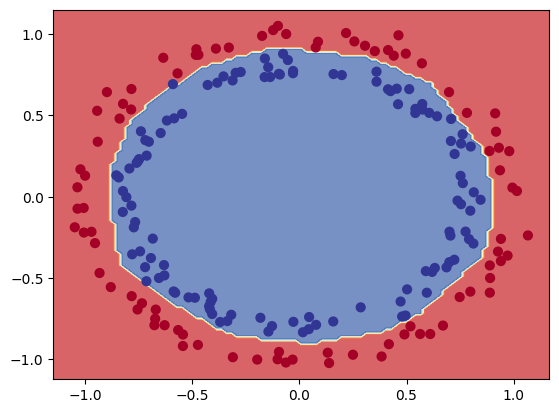

In [25]:
plot_decision_boundary(model1, X_test, y_test)